# Spacing

Space instances of motifs.

In [308]:
import numpy as np
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
import pyBigWig
from matplotlib.patches import Rectangle
from copy import deepcopy
from collections import defaultdict, OrderedDict
import itertools
from deeplift.dinuc_shuffle import dinuc_shuffle

In [3]:
from random import shuffle, choice, random
from copy import deepcopy

In [4]:
from modisco.visualization import viz_sequence

In [5]:
from random import choice, sample
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [6]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [530]:
from shaputils import *
import shap

In [564]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx4/extra_models/P2qbCl.h5")

    model_int = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx2/2021-04-14_18_11_26/Dp2D6w.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
    model_neur = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx5/2021-04-14_18_11_26/nqv4wJ.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx8/2021-04-14_18_11_26/HhcfZk.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx1/2021-04-14_18_11_26/89fam2.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx14/2021-04-15_09_22_38/Y4lI6R.h5")
    model_ipsc = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/2021-04-15_09_33_42/7zunw4.h5")

In [565]:
models = [model_neur, model_int, model_ipsc]

In [10]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [12]:
MODEL_INP_LEN = models[0].input_shape[0][1]
MODEL_OUT_LEN = models[0].output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

2346
2000


In [23]:
def mod_sequence(s, start, to_add):
    cur = s[:start]
    cur += to_add
    cur += s[start+len(to_add):]
    
    return cur

In [24]:
def revcomp(s):
    REVCOMP = {"A":"T", "C":"G", "G":"C", "T":"A"}
    return "".join(REVCOMP[x] for x in s.upper())[::-1]

In [467]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

In [468]:
softmax(np.array([[1,2],[2,2]]))

array([[0.26894142, 0.73105858],
       [0.5       , 0.5       ]])

In [418]:
def single_marginalize(coords, models, mot, mot_pos=MODEL_INP_LEN//2, mot_offsets=range(100,5), batch_size=128):
    # offsets are from mot_pos
    
    synth_pred_counts = [defaultdict(list) for _ in models]
    synth_pred_profiles = [defaultdict(list) for _ in models]
    
    for i in tqdm.tqdm(range(math.ceil(len(coords)/BATCH_SIZE))):
        cur_seqs = coords[i*BATCH_SIZE:(i+1)*BATCH_SIZE]        
        
        for offset in mot_offsets:
            cur_raw_seqs = []
            
            for j, r in enumerate(cur_seqs):
                if isinstance(r, tuple):
                    cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
                elif isinstance(r, str):
                    cur_raw_seqs.append(r)
                
                cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], mot_pos + offset, mot)

            cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
            
            for k,m in enumerate(models):
                cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])

                synth_pred_profiles[k][offset].append(cur_pred[0])
                synth_pred_counts[k][offset].append(cur_pred[1])
            
    synth_pred_profiles = [{y:np.vstack(z) for y,z in x.items()} for x in synth_pred_profiles]
    synth_pred_counts = [{y:np.vstack(z).ravel() for y,z in x.items()} for x in synth_pred_counts]
    
    return synth_pred_counts, synth_pred_profiles

In [413]:
def pairwise_marginalize(coords, models, mot1, mot2, mot1_pos=MODEL_INP_LEN//2, mot2_pos=range(100,5), batch_size=128):
    # mot1 is placed at mot1_pos
    # mot2 are placed at offsets from mot1_pos+len(mot1)
    
    synth_pred_counts = [defaultdict(list) for _ in models]
    synth_pred_profiles = [defaultdict(list) for _ in models]
    
    for i in tqdm.tqdm(range(math.ceil(len(coords)/BATCH_SIZE))):
        cur_seqs = coords[i*BATCH_SIZE:(i+1)*BATCH_SIZE]        
        
        for offset in mot2_pos:
            cur_raw_seqs = []
            
            for j, r in enumerate(cur_seqs):
                if isinstance(r, tuple):
                    cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
                elif isinstance(r, str):
                    cur_raw_seqs.append(r)

                cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], mot1_pos, mot1)
                
                cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], mot1_pos + len(mot1) + offset, mot2)

            cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
            
            for k,m in enumerate(models):
                cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])
                synth_pred_profiles[k][offset].append(cur_pred[0])
                synth_pred_counts[k][offset].append(cur_pred[1])
    
    synth_pred_profiles = [{y:np.vstack(z) for y,z in x.items()} for x in synth_pred_profiles]
    synth_pred_counts = [{y:np.vstack(z).ravel() for y,z in x.items()} for x in synth_pred_counts]
    
    return synth_pred_counts, synth_pred_profiles

In [100]:
random_positions = []

for i in range(128*10):
    chrm = choice(["chr"+str(x) for x in range(1,23)])
    pos = int(random()*(len(hg38[chrm])-2000))
    random_positions.append((chrm,pos))

In [444]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts = [[] for _ in models]
random_pred_profiles = [[] for _ in models]

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    for j,m in enumerate(models):
        cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])
        random_pred_profiles[j].append(cur_pred[0])
        random_pred_counts[j].append(cur_pred[1])

random_pred_profiles = [np.vstack(x) for x in random_pred_profiles]
random_pred_counts = [np.vstack(x).ravel() for x in random_pred_counts]

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [445]:
[np.median(x) for x in random_pred_counts]

[2.0382254, 4.181613, 4.454468]

In [446]:
MOT2_POS = list(itertools.chain(range(-5,50),
                                range(50,100,5)))

In [440]:
# MOT2_POS = [1, 10]

In [441]:
all_mots = OrderedDict({"OCTSOX":"ATTTGCATAACAATG",
                       "SOX":"GAACAATAG",
                       "KLF":"TGGGTGTGGC"})

In [ ]:
pairwise_profiles = defaultdict(dict)
pairwise_counts = defaultdict(dict)

# pairwise
for i in range(len(all_mots)):
    for j in range(i, len(all_mots)):        
        mot1_name, mot1_seq = list(all_mots.items())[i]
        mot2_name, mot2_seq = list(all_mots.items())[j]
        
        for rev1, rev2 in itertools.product([False, True], [False, True]):
            cur_mot1_seq = revcomp(mot1_seq) if rev1 else mot1_seq
            cur_mot2_seq = revcomp(mot2_seq) if rev2 else mot2_seq
            
            synth_pred_counts, synth_pred_profiles = pairwise_marginalize(random_positions, 
                                                     models,
                                                     cur_mot1_seq, 
                                                     cur_mot2_seq, 
                                                     mot1_pos=MODEL_INP_LEN//2 - len(cur_mot1_seq), 
                                                     mot2_pos=MOT2_POS)
            
            pairwise_profiles[(mot1_name, mot2_name)][(rev1, rev2)] = synth_pred_profiles
            pairwise_counts[(mot1_name, mot2_name)][(rev1, rev2)] = synth_pred_counts

 40%|████      | 4/10 [03:32<05:18, 53.00s/it]

In [ ]:
mot1_counts = defaultdict(dict)
mot1_profiles = defaultdict(dict)
mot2_counts = defaultdict(dict)
mot2_profiles = defaultdict(dict)

# single, as either mot1 or mot2
for i in range(len(all_mots)):
    mot_name, mot_seq = list(all_mots.items())[i]

    for rev in [False, True]:
        cur_mot_seq = revcomp(mot_seq) if rev else mot_seq
        
        cur_counts, cur_profiles = single_marginalize(random_positions, 
                                                        models, 
                                                        cur_mot_seq, 
                                                        mot_pos=MODEL_INP_LEN//2-len(cur_mot_seq), 
                                                        mot_offsets=[0], 
                                                        batch_size=128)
        mot1_counts[mot_name][rev] = cur_counts
        mot1_profiles[mot_name][rev] = cur_profiles
        
        cur_counts, cur_profiles = single_marginalize(random_positions, 
                                                        models, 
                                                        cur_mot_seq, 
                                                        mot_pos=MODEL_INP_LEN//2, 
                                                        mot_offsets=MOT2_POS, 
                                                        batch_size=128)
        
        mot2_counts[mot_name][rev] = cur_counts
        mot2_profiles[mot_name][rev] = cur_profiles

In [155]:
from scipy.stats import spearmanr

In [154]:
# ensure counts on random seqs and after manipulation are correlated
spearmanr(random_pred_counts[0], pairwise_counts[("SOX", "KLF")][config][0][0])

SpearmanrResult(correlation=0.8440250360813939, pvalue=0.0)

(1280, 2000, 1)

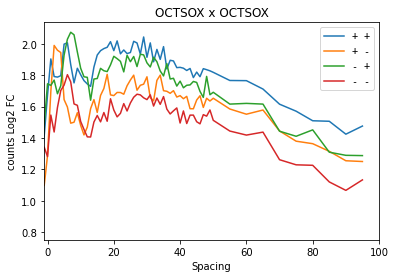

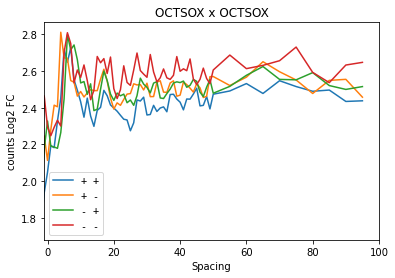

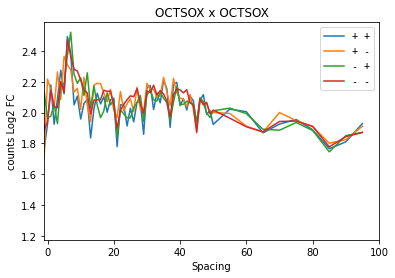

In [517]:
PICK_PAIR = ("OCTSOX", "OCTSOX")

for i in range(len(models)):
    for config in itertools.product([False, True], [False, True]):
        lab1 = '-' if config[0] else '+'
        lab2 = '-' if config[1] else '+'
        plt.plot(MOT2_POS, 
                 [np.log2(np.e)*np.median(pairwise_counts[PICK_PAIR][config][i][x] - \
                           random_pred_counts[i]) for x in MOT2_POS],
                 '-',
                label=lab1+" " +lab2)
#     plt.plot(MOT2_POS, [K_median_deltas_mot2[i][x] for x in MOT2_POS])
#     plt.hlines(OS_median_deltas_mot1[i], min(MOT2_POS), max(MOT2_POS))
#     plt.plot(MOT2_POS, [K_median_deltas_mot2[i][x]+OS_median_deltas_mot1[i] for x in MOT2_POS])
    plt.xlim(-1,100)
    plt.ylabel("counts Log2 FC")
    plt.xlabel("Spacing")
    plt.title("{:s} x {:s}".format(*PICK_PAIR))
    plt.legend(prop={'family': 'monospace'})
    plt.show()

In [293]:
np.median(mot2_counts["OCTSOX"][False][0][10]- random_pred_counts[0])

0.4448079

In [292]:
np.median(mot2_counts["OCTSOX"][True][0][10]- random_pred_counts[0])

0.3011093

In [279]:
np.median(mot2_counts["OCTSOX"][False][2][0]- random_pred_counts[2])

0.75463724

In [283]:
np.median(mot2_counts["OCTSOX"][True][2][0]- random_pred_counts[2])

0.754022

In [274]:
np.median(mot2_counts["OCTSOX"][False][1][0]- random_pred_counts[1])

1.0806148

In [268]:
np.median(mot1_counts["SOX"][True][1][0]- random_pred_counts[1])

0.029120684

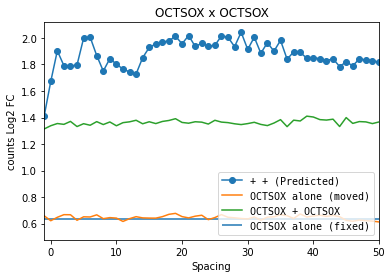

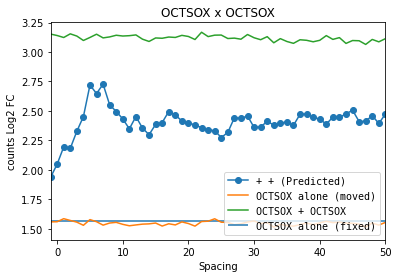

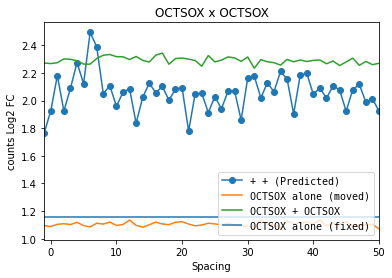

In [519]:
PICK_STRAND = (False, False)
PICK_PAIR = ("OCTSOX", "OCTSOX")
XMIN=-1
XMAX=50
LOG2_FAC = np.log2(np.e)

for i in range(len(models)):
    lab1 = '-' if PICK_STRAND[0] else '+'
    lab2 = '-' if PICK_STRAND[1] else '+'
    plt.plot(MOT2_POS, 
             [LOG2_FAC*np.median(pairwise_counts[PICK_PAIR][PICK_STRAND][i][x] - \
                       random_pred_counts[i]) for x in MOT2_POS],
             '-o',
            label=lab1+" " +lab2 + " (Predicted)")
    
    plt.hlines(LOG2_FAC*np.median(mot1_counts[PICK_PAIR[0]][PICK_STRAND[0]][i][0] - random_pred_counts[i]), 
               XMIN, XMAX,
              label="{:s} alone (fixed)".format(PICK_PAIR[0]))
    
    plt.plot(MOT2_POS,
             [LOG2_FAC*np.median(mot2_counts[PICK_PAIR[1]][PICK_STRAND[1]][i][x] - \
                                random_pred_counts[i]) for x in MOT2_POS],
            label="{:s} alone (moved)".format(PICK_PAIR[1]))
    
    plt.plot(MOT2_POS,
             [LOG2_FAC*np.median(mot2_counts[PICK_PAIR[1]][PICK_STRAND[1]][i][x] + \
                                 mot1_counts[PICK_PAIR[0]][PICK_STRAND[0]][i][0] - \
                                2*random_pred_counts[i]) for x in MOT2_POS],
            label="{:s} + {:s}".format(*PICK_PAIR))
             
    
    #     plt.plot(MOT2_POS, [K_median_deltas_mot2[i][x] for x in MOT2_POS])
    #     plt.hlines(OS_median_deltas_mot1[i], min(MOT2_POS), max(MOT2_POS))
    #     plt.plot(MOT2_POS, [K_median_deltas_mot2[i][x]+OS_median_deltas_mot1[i] for x in MOT2_POS])
    plt.xlim(XMIN,XMAX)
    plt.ylabel("counts Log2 FC")
    plt.xlabel("Spacing")
    plt.title("{:s} x {:s}".format(*PICK_PAIR))
    plt.legend(prop={'family': 'monospace'}, loc='lower right')
    plt.show()

In [475]:
np.array([[1],[2]]).shape

(2, 1)

In [482]:
np.expand_dims(np.array([1,2,3]), 1).shape

(3, 1)

In [481]:
np.array([[1,2],[3,4],[5,6]])*np.array([1,2,3])

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [479]:
pairwise_counts[PICK_PAIR][PICK_STRAND][0][0].shape

(1280,)

In [480]:
softmax(pairwise_profiles[PICK_PAIR][PICK_STRAND][0][0].squeeze()).shape

(1280, 2000)

[<matplotlib.lines.Line2D at 0x7f245c1c8b50>]

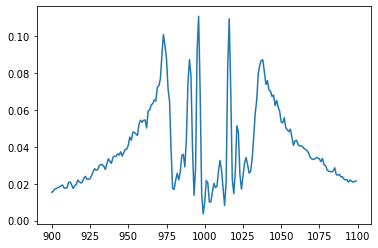

In [508]:
cur_pair_prof = np.expand_dims(np.exp(pairwise_counts[PICK_PAIR][PICK_STRAND][0][10]), 1) * softmax(pairwise_profiles[PICK_PAIR][PICK_STRAND][0][10].squeeze())
cur_random_prof = np.expand_dims(np.exp(random_pred_counts[0]), 1) * softmax(random_pred_profiles[0].squeeze())

plt.plot(range(900,1100),
         np.median(cur_pair_prof-cur_random_prof, axis=0)[900:1100],
                 '-')

[<matplotlib.lines.Line2D at 0x7f250036b1d0>]

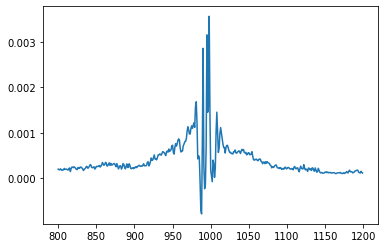

In [489]:
cur_single_prof = np.expand_dims(np.exp(mot1_counts[PICK_PAIR[0]][PICK_STRAND[0]][0][0]), 1) * softmax(mot1_profiles[PICK_PAIR[0]][PICK_STRAND[0]][0][0].squeeze())
cur_random_prof = np.expand_dims(np.exp(random_pred_counts[0]), 1) * softmax(random_pred_profiles[0].squeeze())

plt.plot(range(800,1200),
         np.median(cur_single_prof-cur_random_prof, axis=0)[800:1200],
                 '-')

[<matplotlib.lines.Line2D at 0x7f24146e7a50>]

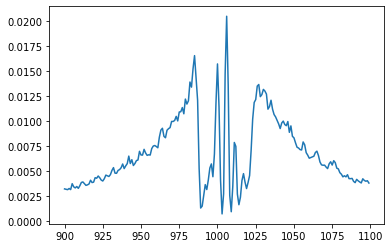

In [492]:
cur_single_prof = np.expand_dims(np.exp(mot2_counts[PICK_PAIR[1]][PICK_STRAND[1]][0][0]), 1) * softmax(mot2_profiles[PICK_PAIR[1]][PICK_STRAND[1]][0][0].squeeze())
cur_random_prof = np.expand_dims(np.exp(random_pred_counts[0]), 1) * softmax(random_pred_profiles[0].squeeze())

plt.plot(range(900,1100),
         np.median(cur_single_prof-cur_random_prof, axis=0)[900:1100],
                 '-')

In [ ]:
# GIF (tmp method)

In [498]:
import imageio

In [513]:
PICK_STRAND = (False, False)
PICK_PAIR = ("OCTSOX", "OCTSOX")

for i in range(50):
    cur_pair_prof = np.expand_dims(np.exp(pairwise_counts[PICK_PAIR][PICK_STRAND][0][i]), 1) * softmax(pairwise_profiles[PICK_PAIR][PICK_STRAND][0][i].squeeze())
    cur_random_prof = np.expand_dims(np.exp(random_pred_counts[0]), 1) * softmax(random_pred_profiles[0].squeeze())

    plt.plot(range(800,1200),
             np.median(cur_pair_prof-cur_random_prof, axis=0)[800:1200],
                     '-')
    plt.ylim(0,0.08)
    plt.title("Spacing = {:d}".format(i))
    plt.savefig('./tmp/{:d}'.format(i))
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [514]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in ["./tmp/{:d}.png".format(i) for i in range(50)]:
        image = imageio.imread(filename)
        writer.append_data(image)

### Save session outputs

In [522]:
import joblib

In [521]:
SESS_PATH = "./spacing_sessions/20210517_neur_int_preipsc/"

In [525]:
save_dict = {"random_positions":random_positions,
             "random_pred_counts": random_pred_counts,
             "random_pred_profiles": random_pred_profiles,
             "motifs": all_mots,
             "pairwise_counts": pairwise_counts,
             "pairwise_profiles": pairwise_profiles,
             "mot1_counts": mot1_counts,
             "mot1_profiles": mot1_profiles,
             "mot2_counts": mot2_counts,
             "mot2_profiles": mot2_profiles
            }

In [526]:
joblib.dump(save_dict, SESS_PATH + "session.joblib", compress=3)

['./spacing_sessions/20210517_neur_int_preipsc/session.joblib']

### With Dinuc Shuffled

For one model (high OSK [neur]) checking if there are differences between using random sequences or using peaks after dinucleotide shuffling or using peaks themselves.

Looks like results from using random sequences and dinuc shuffling are identical.

Using peaks themselves results in damped effects, which is to be expected.

In [ ]:
# for neur only first

In [315]:
neur_peaks = pd.read_csv("/users/surag/oak/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx4/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz",
                         names=["chr", "start", "end", "v1", "v2","v3","v4","v5","v6", "summit"],
                        sep='\t')
neur_peaks.head()

,chr,start,end,v1,v2,v3,v4,v5,v6,summit
0,chr1,100005417,100006194,Peak_208971,75,.,4.07240,7.59397,5.77510,187
1,chr1,100005417,100006194,Peak_33949,433,.,12.24018,43.35997,40.61578,460
2,chr1,100012863,100013085,Peak_254438,55,.,3.93983,5.52344,3.80661,118
3,chr1,100020546,100020938,Peak_8284,840,.,20.94241,84.04413,80.59457,171
4,chr1,100025652,100026422,Peak_168047,100,.,4.98132,10.04301,8.11562,181


In [316]:
sampled_neur_peaks = neur_peaks.sample(1280)

In [344]:
sampled_neur_peaks_seqs = [str(hg38[x[0]][x[1]+x[9]-MODEL_INP_LEN//2:x[1]+x[9]+MODEL_INP_LEN//2]) for  \
                                   _,x in sampled_neur_peaks.iterrows()]
sampled_neur_peaks_seqs_shuffed = [dinuc_shuffle(x) for x in sampled_neur_peaks_seqs]

In [345]:
BATCH_SIZE = 128

dinuc_random_pred_counts = [[] for _ in models]

for i in tqdm.tqdm(range(math.ceil(len(sampled_neur_peaks_seqs_shuffed)/BATCH_SIZE))):
    cur_raw_seqs = sampled_neur_peaks_seqs_shuffed[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    for j,m in enumerate(models):
        cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        dinuc_random_pred_counts[j].append(cur_pred)
        
dinuc_random_pred_counts = [np.vstack(x).ravel() for x in dinuc_random_pred_counts]

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [537]:
BATCH_SIZE = 128

dinuc_random_pred_counts = [[] for _ in models]

for i in tqdm.tqdm(range(math.ceil(len(sampled_neur_peaks_seqs_shuffed)/BATCH_SIZE))):
    cur_raw_seqs = sampled_neur_peaks_seqs_shuffed[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    for j,m in enumerate(models):
        cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        dinuc_random_pred_counts[j].append(cur_pred)
        
dinuc_random_pred_counts = [np.vstack(x).ravel() for x in dinuc_random_pred_counts]

NameError: name 'models' is not defined

In [346]:
BATCH_SIZE = 128

notdinuc_random_pred_counts = [[] for _ in models]

for i in tqdm.tqdm(range(math.ceil(len(sampled_neur_peaks_seqs)/BATCH_SIZE))):
    cur_raw_seqs = sampled_neur_peaks_seqs[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    for j,m in enumerate(models):
        cur_pred = m.predict([cur_raw_seqs, 
                    np.zeros((cur_raw_seqs.shape[0],1)), 
                    np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        notdinuc_random_pred_counts[j].append(cur_pred)
        
notdinuc_random_pred_counts = [np.vstack(x).ravel() for x in notdinuc_random_pred_counts]

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [347]:
[np.median(x) for x in notdinuc_random_pred_counts]

[4.3604126, 5.782811, 5.443592]

In [348]:
[np.median(x) for x in dinuc_random_pred_counts]

[2.1792955, 4.43458, 4.7636123]

In [368]:
[np.median(x) for x in random_pred_counts]

[2.0382254, 4.181613, 4.454468]

In [391]:
dinuc_SOX_KLF_plus_plus = pairwise_marginalize(sampled_neur_peaks_seqs_shuffed, 
                                                     models[:1],
                                                     all_mots["SOX"], 
                                                     all_mots["KLF"], 
                                                     mot1_pos=MODEL_INP_LEN//2 - len(all_mots["SOX"]), 
                                                     mot2_pos=range(20))

100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


In [359]:
notdinuc_SOX_KLF_plus_plus = pairwise_marginalize(sampled_neur_peaks_seqs, 
                                                     models[:1],
                                                     all_mots["SOX"], 
                                                     all_mots["KLF"], 
                                                     mot1_pos=MODEL_INP_LEN//2 - len(all_mots["SOX"]), 
                                                     mot2_pos=range(20))

100%|██████████| 10/10 [00:55<00:00,  5.55s/it]


In [358]:
dinuc_SOX_KLF_minus_minus = pairwise_marginalize(sampled_neur_peaks_seqs_shuffed, 
                                                     models[:1],
                                                     revcomp(all_mots["SOX"]), 
                                                     revcomp(all_mots["KLF"]), 
                                                     mot1_pos=MODEL_INP_LEN//2 - len(all_mots["SOX"]), 
                                                     mot2_pos=range(20))

100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


In [359]:
notdinuc_SOX_KLF_minus_minus = pairwise_marginalize(sampled_neur_peaks_seqs, 
                                                     models[:1],
                                                     revcomp(all_mots["SOX"]), 
                                                     revcomp(all_mots["KLF"]), 
                                                     mot1_pos=MODEL_INP_LEN//2 - len(all_mots["SOX"]), 
                                                     mot2_pos=range(20))

100%|██████████| 10/10 [00:55<00:00,  5.55s/it]


In [351]:
spearmanr(dinuc_SOX_KLF_plus_plus[0][0], dinuc_random_pred_counts[0])

SpearmanrResult(correlation=0.7485826197556273, pvalue=2.5300746609872097e-230)

In [353]:
spearmanr(notdinuc_SOX_KLF_plus_plus[0][0], notdinuc_random_pred_counts[0])

SpearmanrResult(correlation=0.8376389313592111, pvalue=0.0)

(0.0, 20.0)

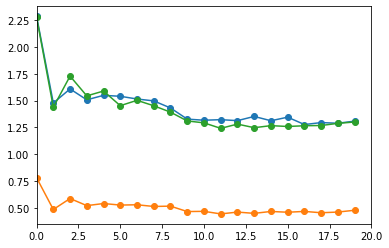

In [392]:
CUR_POS = range(20)
plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(dinuc_SOX_KLF_plus_plus[0][x] - \
                           dinuc_random_pred_counts[0]) for x in CUR_POS],
                 '-o')

plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(notdinuc_SOX_KLF_plus_plus[0][x] - \
                           notdinuc_random_pred_counts[0]) for x in CUR_POS],
                 '-o')


plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(pairwise_counts[("SOX", "KLF")][(False, False)][0][x] - \
                           random_pred_counts[0]) for x in CUR_POS],
                 '-o')

plt.xlim(0,20)

(0.0, 20.0)

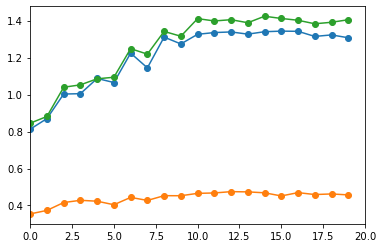

In [360]:
CUR_POS = range(20)

plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(dinuc_SOX_KLF_minus_minus[0][x] - \
                           dinuc_random_pred_counts[0]) for x in CUR_POS],
                 '-o')

plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(notdinuc_SOX_KLF_minus_minus[0][x] - \
                           notdinuc_random_pred_counts[0]) for x in CUR_POS],
                 '-o')


plt.plot(CUR_POS, 
                 [np.log2(np.e)*np.median(pairwise_counts[("SOX", "KLF")][(True, True)][0][x] - \
                           random_pred_counts[0]) for x in CUR_POS],
                 '-o')

plt.xlim(0,20)

In [422]:
np.median(single_marginalize(sampled_neur_peaks_seqs_shuffed, 
                   models[:1], 
                   all_mots["OCTSOX"], 
                   mot_pos=MODEL_INP_LEN//2, 
                   mot_offsets=[0], 
                   batch_size=128)[0][0][0] - dinuc_random_pred_counts[0])

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


0.48220563

In [421]:
np.median(single_marginalize(sampled_neur_peaks_seqs_shuffed, 
                   models[:1], 
                   revcomp(all_mots["OCTSOX"]), 
                   mot_pos=MODEL_INP_LEN//2, 
                   mot_offsets=[0], 
                   batch_size=128)[0][0][0] - dinuc_random_pred_counts[0])

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


0.3183425

# TMP

In [559]:
from itertools import combinations, product

def all_muts(s, n):
    muts = [s]
    subs = [[y for y in ["A","C","G","T"] if y!=x] for x in s]
    
    for x in combinations(range(len(s)), n):
        cur_subs = product(*[subs[y] for y in x])
        
        for bases in cur_subs:
            cur_str = ""
            j = 0
            for i in range(len(x)):                
                cur_str += s[j:x[i]] + bases[i]
                j = x[i]+1
            cur_str += s[j:]

            muts.append(cur_str)
    
    return muts

In [560]:
all_KLF_one_muts = all_muts("GCCACACCCA",1)
all_OS_one_muts = all_muts("ATTTGCATAACAATG",1)
all_O_one_muts = all_muts("ATTTGCATAA",1)
print(len(all_KLF_one_muts))
print(len(all_OS_one_muts))
print(len(all_O_one_muts))

31
46
31


In [561]:
all_KLF_two_muts = all_muts("GCCACACCCA",2)
all_OS_two_muts = all_muts("ATTTGCATAACAATG",2)
all_O_two_muts = all_muts("ATTTGCATAA",2)
print(len(all_KLF_two_muts))
print(len(all_OS_two_muts))
print(len(all_O_two_muts))

406
946
406


In [630]:
all_OS_tail_muts = [x+"GCATAACAATG" for x in sum([all_muts("ATTT", i) for i in range(1,5)], [])]
all_OS_GCAT_muts = ["ATTT"+x +"AACAATG" for x in sum([all_muts("GCAT", i) for i in range(1,5)], [])]
all_OS_ACAAT_muts = ["ATTTGCATA"+x + "G" for x in sum([all_muts("ACAAT", i) for i in range(1,6)], [])]
print(len(all_OS_tail_muts))
print(len(all_OS_GCAT_muts))
print(len(all_OS_ACAAT_muts))

259
259
1028


In [669]:
REPLACE_WITH = all_KLF_two_muts + all_KLF_one_muts
REPLACE_WITH_WID = len(REPLACE_WITH[0])

In [670]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts_muts = []

        
motif_start = MODEL_INP_LEN//2 
motif_end = MODEL_INP_LEN//2 + REPLACE_WITH_WID


for i in tqdm.tqdm(range(len(random_positions[:128]))):
    cur_seq = random_positions[i]
    cur_raw_seqs = []
    cur_seq = str(hg38[cur_seq[0]][cur_seq[1]-(MODEL_INP_LEN//2):cur_seq[1]+(MODEL_INP_LEN//2)])
    
    for j, r in enumerate(REPLACE_WITH):
        cur_raw_seqs.append(cur_seq[:motif_start] +  r + cur_seq[motif_end:])
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = models[2].predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts_muts.append(cur_pred)

100%|██████████| 128/128 [02:00<00:00,  1.07it/s]


In [685]:
deltas = np.squeeze(np.array(synth_pred_counts_muts)) - np.expand_dims(random_pred_counts[2][:128], axis=1)

deltas_mean = np.mean(deltas, axis=0)

In [703]:
OS_pfm = np.loadtxt("../../../resources/BPNet/motifs/Oct4-Sox2/PFM.txt")

# rev comp
OS_pfm = OS_pfm[::-1, ::-1][:-1]
OS_pfm

array([[0.47719233, 0.14103519, 0.14541054, 0.23636194],
       [0.06013778, 0.06516477, 0.03760938, 0.83708807],
       [0.11943772, 0.17138336, 0.04943214, 0.65974679],
       [0.28830758, 0.01638429, 0.03891268, 0.65639546],
       [0.21178551, 0.0960715 , 0.66989387, 0.02224912],
       [0.13181903, 0.85077267, 0.00651648, 0.01089183],
       [0.97737851, 0.00512009, 0.00288587, 0.01461553],
       [0.05185254, 0.0349097 , 0.00763359, 0.90560417],
       [0.40886241, 0.14056973, 0.21979147, 0.23077639],
       [0.65611618, 0.01787377, 0.00837833, 0.31763173],
       [0.07419475, 0.56097561, 0.27788121, 0.08694843],
       [0.94814746, 0.01638429, 0.00307205, 0.0323962 ],
       [0.94498231, 0.01796686, 0.03183765, 0.00521318],
       [0.47961274, 0.02532117, 0.03444424, 0.46062186],
       [0.36017501, 0.05092162, 0.51256749, 0.07633588]])

In [704]:
''.join(np.array(["A","C","G","T"])[np.argmax(OS_pfm, axis=1)])

'ATTTGCATAACAAAG'

In [674]:
REPLACE_WITH[:10]

['GCCACACCCA',
 'AACACACCCA',
 'AGCACACCCA',
 'ATCACACCCA',
 'CACACACCCA',
 'CGCACACCCA',
 'CTCACACCCA',
 'TACACACCCA',
 'TGCACACCCA',
 'TTCACACCCA']

In [756]:
K_pfm = np.loadtxt("../../../resources/BPNet/motifs/Klf4/PFM.txt")

# rev comp
# K_pfm = K_pfm[::-1, ::-1][:-1]
K_pfm

array([[3.20174959e-01, 4.77856752e-02, 5.80098414e-01, 5.19409513e-02],
       [9.78676873e-02, 7.59103335e-01, 3.28048114e-02, 1.10224166e-01],
       [5.60962274e-02, 7.18097321e-01, 1.22471296e-02, 2.13559322e-01],
       [6.37069437e-01, 3.49808639e-01, 8.09185347e-03, 5.03007108e-03],
       [8.74794970e-04, 9.98359759e-01, 0.00000000e+00, 7.65445599e-04],
       [6.19901586e-01, 0.00000000e+00, 3.07053034e-01, 7.30453800e-02],
       [1.09349371e-04, 9.99453253e-01, 1.09349371e-04, 3.28048114e-04],
       [0.00000000e+00, 9.99781301e-01, 0.00000000e+00, 2.18698742e-04],
       [5.46746856e-04, 9.65008201e-01, 0.00000000e+00, 3.44450519e-02],
       [4.02296337e-01, 1.10333516e-01, 6.04702023e-02, 4.26899945e-01]])

In [714]:
''.join(np.array(["A","C","G","T"])[np.argmax(K_pfm, axis=1)])

'GCCACACCCT'

In [716]:
OS_logodds = np.log(OS_pfm/0.25)

In [747]:
K_logodds = np.log((K_pfm+1e-4)/0.25)

In [748]:
logodds_scores = np.sum((K_logodds * one_hot.dna_to_one_hot(REPLACE_WITH)), axis=(1,2))
logodds_scores[:10]

array([10.83536919,  8.19354699,  7.10252818,  8.31233228,  6.29318352,
        5.20216471,  6.41196881,  6.37639805,  5.28537924,  6.49518334])

In [749]:
# spearmanr(logodds_scores, logodds_bpnet_scores)

In [750]:
print(pearsonr(deltas_mean, logodds_scores)[0])
print(spearmanr(deltas_mean, logodds_scores)[0])

0.22571120485108134
0.15140198036417687


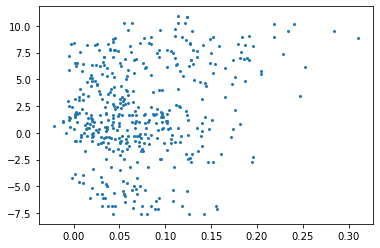

In [751]:
plt.scatter(deltas_mean, logodds_scores, s=4)

In [752]:
np.where(np.logical_and(deltas_mean<0.02, logodds_scores>7.5))

(array([  3,  84,  91, 409]),)

In [753]:
logodds_scores[np.where(np.logical_and(deltas_mean<0.02, logodds_scores>7.5))[0]]

array([8.31233228, 7.5753757 , 8.18837373, 8.42402999])

In [754]:
deltas_mean[np.where(np.logical_and(deltas_mean<0.02, logodds_scores>7.5))[0]]

array([-0.00242086,  0.00685269,  0.01456635,  0.00058308], dtype=float32)

In [762]:
logodds_scores[0]

10.83536919213445

In [760]:
K_logodds

array([[ 0.24771896, -1.65264451,  0.84190922, -1.56942998],
       [-0.93682322,  1.11080872, -2.02784203, -0.81803792],
       [-1.49261129,  1.05528343, -3.0080373 , -0.15707812],
       [ 0.93557469,  0.33621117, -3.41832074, -3.8863414 ],
       [-5.54698904,  1.38475293, -7.82404601, -5.66597168],
       [ 0.90826112, -7.82404601,  0.20588519, -1.22901195],
       [-7.08521171,  1.38584751, -7.08521171, -6.36998059],
       [-7.82404601,  1.38617566, -7.82404601, -6.66496992],
       [-5.95726124,  1.3507793 , -7.82404601, -1.97919659],
       [ 0.4759766 , -0.81704725, -1.41765786,  0.53532297]])

In [745]:
REPLACE_WITH[0]

'GCCACACCCA'

In [744]:
REPLACE_WITH[3]

'ATCACACCCA'

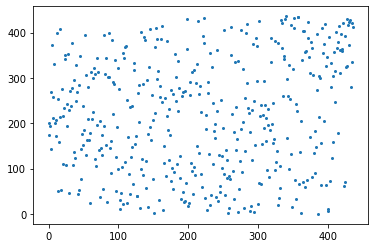

In [723]:
plt.scatter(np.argsort(np.argsort(deltas_mean)), 
            np.argsort(np.argsort(logodds_scores)), 
                       s=4)